In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

from google.colab import files

In [4]:
uploaded = files.upload()

Saving forestfires.csv to forestfires.csv


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "forestfires.csv" with length 25478 bytes


In [0]:
import io
forestfire = pd.read_csv(io.StringIO(uploaded['forestfires.csv'].decode('utf-8')))


In [7]:
forestfire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [0]:
def preprocess_features(forestfire):
  """Prepares input features from data set.

  Args:
    forestfire: A Pandas DataFrame expected to contain data
      from the forestfire data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = forestfire[
    ["DMC",
     "DC",
     "ISI",
     "temp",
     "RH",
     "wind",
     "rain"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["syfunction"] = (
    forestfire["DMC"] /
    forestfire["DC"])
  return processed_features

def preprocess_targets(forestfire):
  """Prepares target features (i.e., labels) from forestfire data set.

  Args:
    Forestfire: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  output_targets["area_high"] = (
    forestfire["area"] > 53).astype(float)
  return output_targets

In [56]:
# Number of data from the total datasets
training_examples = preprocess_features(forestfire.head(450))
training_targets = preprocess_targets(forestfire.head(450))


validation_examples = preprocess_features(forestfire.tail(100))
validation_targets = preprocess_targets(forestfire.tail(100))


print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,DMC,DC,ISI,temp,RH,wind,rain,syfunction
count,450.0,450.0,450.0,450.0,450.0,450.0,450.0,450.0
mean,107.2,549.2,8.8,18.4,43.7,3.9,0.0,0.2
std,61.9,249.0,4.4,5.4,15.9,1.8,0.0,0.1
min,1.1,7.9,0.0,2.2,15.0,0.4,0.0,0.0
25%,61.0,441.2,6.3,15.4,33.0,2.7,0.0,0.1
50%,104.2,665.3,8.2,19.1,41.0,3.6,0.0,0.2
75%,137.0,714.2,10.4,22.1,52.0,4.9,0.0,0.3
max,291.3,860.6,56.1,30.8,100.0,9.4,1.0,0.6


Validation examples summary:


,DMC,DC,ISI,temp,RH,wind,rain,syfunction
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,152.8,565.3,10.1,21.7,48.0,4.3,0.1,0.3
std,79.7,244.0,4.8,6.7,17.8,1.8,0.7,0.1
min,3.0,15.3,1.1,4.6,19.0,0.9,0.0,0.0
25%,100.0,560.0,7.1,17.7,33.0,3.1,0.0,0.2
50%,165.4,663.1,8.4,22.0,45.0,4.0,0.0,0.3
75%,209.7,715.1,14.1,26.5,64.0,5.0,0.0,0.3
max,290.0,855.3,21.3,33.3,88.0,9.4,6.4,0.6


Training targets summary:


,area_high
count,450.0
mean,0.0
std,0.2
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,area_high
count,100.0
mean,0.1
std,0.2
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(450)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `forestfire` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `forestfire` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `forestfire` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `forestfire` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 8
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["area_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["area_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["area_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.20
  period 01 : 0.21
  period 02 : 0.22
  period 03 : 0.26
  period 04 : 0.26
  period 05 : 0.26
  period 06 : 0.26
  period 07 : 0.26
Model training finished.


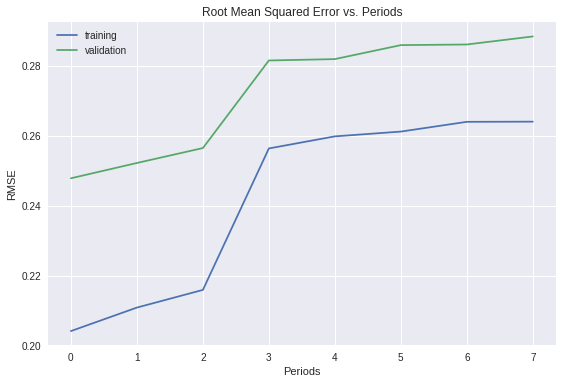

In [67]:
# this is linear regression model(just to compare with the logistic regression model)
linear_regressor = train_linear_regressor_model(
    learning_rate=0.0001,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

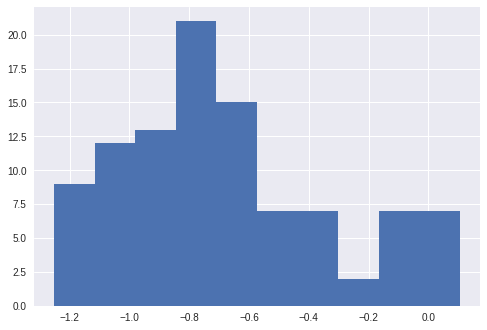

In [60]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["area_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions =linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `forestfire` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `forestfire` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `forestfire` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `forestfire` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["area_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["area_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["area_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss (on training data):"
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_log_loss)
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.53
  period 01 : 0.42
  period 02 : 0.35
  period 03 : 0.31
  period 04 : 0.29
  period 05 : 0.27
  period 06 : 0.26
  period 07 : 0.26
  period 08 : 0.26
  period 09 : 0.26
Model training finished.


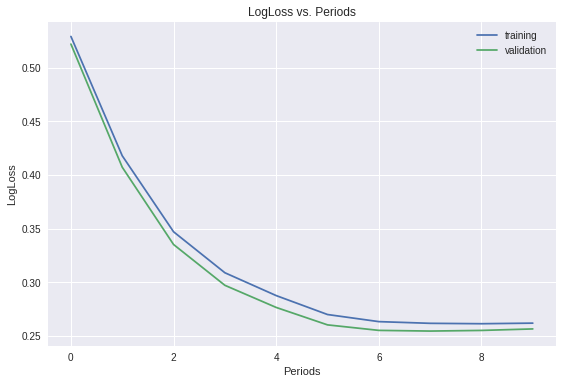

In [68]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=500,
    batch_size=50,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [69]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']

AUC on the validation set: 0.70
Accuracy on the validation set: 0.94


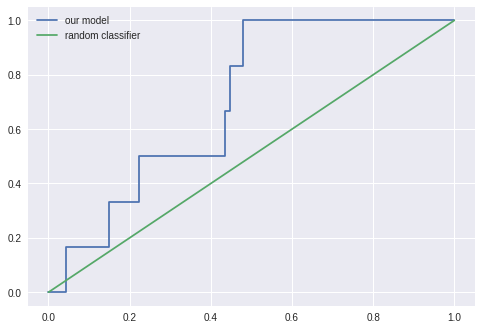

In [70]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

Training model...
LogLoss (on training data):
  period 00 : 0.58
  period 01 : 0.49
  period 02 : 0.41
  period 03 : 0.37
  period 04 : 0.34
  period 05 : 0.31
  period 06 : 0.29
  period 07 : 0.28
  period 08 : 0.27
  period 09 : 0.27
Model training finished.
AUC on the validation set: 0.70
Accuracy on the validation set: 0.94


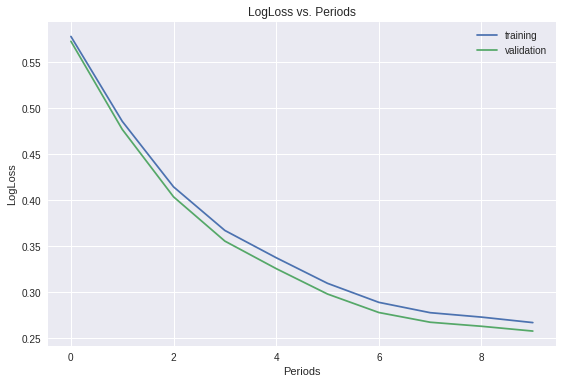

In [82]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=200,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']